In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import warnings

warnings.filterwarnings('ignore')

# Konfigurasi File
file_bbm = 'BBM AAB.xlsx'
file_master = 'cost & bbm 2022 sd 2025.xlsx'

# --- FUNGSI CLEANING ---
def clean_unit_name(name):
    if pd.isna(name): return ""
    name = str(name).upper().strip()
    name = name.replace("FORKLIFT", "FORKLIF")
    name = re.sub(r'[^A-Z0-9]', '', name)
    return name

# --- LOAD MASTER DATA ---
master_data_map = {} 
master_keys_set = set()

if os.path.exists(file_master):
    df_map = pd.read_excel(file_master, sheet_name='Sheet2', header=1)
    
    if 'NAMA ALAT BERAT' in df_map.columns:
        df_map.rename(columns={
            'NAMA ALAT BERAT': 'Unit_Original',
            'ALAT BERAT': 'Jenis_Alat',
            'CAP': 'Capacity'
        }, inplace=True)
    
    df_map.dropna(subset=['Unit_Original'], inplace=True)
    df_map['Unit_ID'] = df_map['Unit_Original'].apply(clean_unit_name)
    df_map = df_map[~df_map['Unit_Original'].astype(str).str.upper().str.contains('DUMMY', na=False)]
    
    # [MANUAL FIX] Capacity L 9025 US = 40
    fix_id = clean_unit_name("L 9025 US")
    df_map.loc[df_map['Unit_ID'] == fix_id, 'Capacity'] = 40
    
    # Cleaning Capacity
    df_map['Capacity'] = pd.to_numeric(df_map['Capacity'], errors='coerce').fillna(0)
    df_map = df_map[df_map['Capacity'] > 0]
    
    for _, row in df_map.iterrows():
        clean_id = row['Unit_ID']
        if clean_id:
            master_data_map[clean_id] = {
                'Unit_Name': row['Unit_Original'],
                'Jenis': row['Jenis_Alat'],
                'Capacity': row['Capacity']
            }
            master_keys_set.add(clean_id)
            
    print(f"✅ Master Data Terbaca: {len(master_data_map)} unit valid.")
else:
    print("❌ File Master tidak ditemukan!")

✅ Master Data Terbaca: 241 unit valid.


In [2]:
raw_data_list = []
target_sheets = ['JAN', 'FEB', 'MAR', 'APR', 'MEI', 'JUN', 'JUL', 'AGT', 'SEP', 'OKT', 'NOV']

print("🔄 Memproses data harian...")

if os.path.exists(file_bbm) and master_data_map:
    xls = pd.ExcelFile(file_bbm)
    
    for sheet in target_sheets:
        if sheet in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet, header=None)
            
            unit_names_row = df.iloc[0].ffill()
            headers = df.iloc[2]
            dates = df.iloc[3:, 0]
            
            for col in range(1, df.shape[1]):
                header_str = str(headers[col]).strip().upper()
                
                if header_str in ['HM', 'LITER', 'KELUAR', 'PEMAKAIAN']:
                    raw_unit_name = str(unit_names_row[col]).strip().upper()
                    
                    if raw_unit_name.startswith(('GENSET', 'KOMPRESSOR', 'MESIN', 'TANGKI', 'SPBU', 'MOBIL', 'UNNAMED', 'TOTAL')):
                        continue
                        
                    clean_trx_id = clean_unit_name(raw_unit_name)
                    matched_id = None
                    
                    # --- SMART MATCHING ---
                    if "FL RENTAL 01" in raw_unit_name and "TIMIKA" not in raw_unit_name:
                        temp_id = clean_unit_name("FL RENTAL 01 TIMIKA")
                        if temp_id in master_data_map: matched_id = temp_id
                    elif "TOBATI" in raw_unit_name and "KALMAR 32T" in raw_unit_name:
                        temp_id = clean_unit_name("TOP LOADER KALMAR 35T/TOBATI") 
                        if temp_id in master_data_map: matched_id = temp_id
                    elif "L 8477 UUC" in raw_unit_name: 
                        temp_id = clean_unit_name("L 9902 UR / S75")
                        if temp_id in master_data_map: matched_id = temp_id
                    elif "L 9054 UT" in raw_unit_name:
                        temp_id = clean_unit_name("L 9054 UT")
                        if temp_id in master_data_map: matched_id = temp_id
                    
                    if not matched_id and clean_trx_id in master_data_map: matched_id = clean_trx_id
                    
                    if not matched_id and " (" in raw_unit_name:
                        try:
                            part_before = raw_unit_name.split("(")[0].strip()
                            clean_before = clean_unit_name(part_before)
                            if clean_before in master_data_map: matched_id = clean_before
                        except: pass
                        
                    if not matched_id and "EX." in raw_unit_name:
                        try:
                            part_after = raw_unit_name.split("EX.")[-1].replace(")", "").strip()
                            clean_after = clean_unit_name(part_after)
                            if clean_after in master_data_map: matched_id = clean_after
                            elif clean_after:
                                for k in master_keys_set:
                                    if clean_after in k: matched_id = k; break
                        except: pass
                    
                    # --- AMBIL DATA ---
                    if matched_id:
                        vals = pd.to_numeric(df.iloc[3:, col], errors='coerce')
                        metric_type = 'HM' if header_str == 'HM' else 'LITER'
                        
                        temp_df = pd.DataFrame({
                            'Date': dates,
                            'Unit_ID': matched_id,
                            'Unit_Name': master_data_map[matched_id]['Unit_Name'],
                            'Metric': metric_type,
                            'Value': vals
                        })
                        temp_df.dropna(subset=['Value', 'Date'], inplace=True)
                        if not temp_df.empty:
                            raw_data_list.append(temp_df)

# --- PROSES AGREGASI (LOGIKA ANALISA.IPYNB) ---
if raw_data_list:
    df_all = pd.concat(raw_data_list, ignore_index=True)
    df_all['Date'] = pd.to_datetime(df_all['Date'], dayfirst=True, errors='coerce')
    df_all.dropna(subset=['Date'], inplace=True)
    
    # Buat Kolom Bulan (Untuk Grouping Nanti)
    df_all['Month_Year'] = df_all['Date'].dt.to_period('M')
    
    # 1. PIVOT (HM & LITER jadi Kolom)
    df_pivot = df_all.pivot_table(
        index=['Unit_ID', 'Unit_Name', 'Date', 'Month_Year'],
        columns='Metric',
        values='Value',
        aggfunc='sum'
    ).reset_index()
    
    if 'HM' not in df_pivot.columns: df_pivot['HM'] = 0
    if 'LITER' not in df_pivot.columns: df_pivot['LITER'] = 0
    
    # Sortir Wajib
    df_pivot.sort_values(by=['Unit_Name', 'Date'], inplace=True)
    
    # 2. HITUNG DELTA HM (Jam Kerja Harian)
    # Replace 0 -> NaN -> FFill (Agar odometer nyambung terus)
    df_pivot['HM_Clean'] = df_pivot['HM'].replace(0, np.nan)
    df_pivot['HM_Clean'] = df_pivot.groupby('Unit_Name')['HM_Clean'].ffill()
    df_pivot['HM_Clean'] = df_pivot['HM_Clean'].fillna(0)
    
    # Diff (Hari ini - Kemarin)
    df_pivot['Delta_HM'] = df_pivot.groupby('Unit_Name')['HM_Clean'].diff().fillna(0)
    
    # Filter Outlier (Minus atau Lonjakan > 100 jam/hari dianggap error)
    df_pivot.loc[df_pivot['Delta_HM'] < 0, 'Delta_HM'] = 0 
    df_pivot.loc[df_pivot['Delta_HM'] > 100, 'Delta_HM'] = 0 
    
    # 3. AGREGASI BULANAN (SIAP UNTUK REGRESI)
    df_monthly = df_pivot.groupby(['Unit_ID', 'Unit_Name', 'Month_Year']).agg({
        'Delta_HM': 'sum',  # Total Jam Kerja Sebenarnya
        'LITER': 'sum'      # Total BBM
    }).reset_index()
    
    # Rename agar sesuai format regresi
    df_monthly.rename(columns={'Delta_HM': 'HM'}, inplace=True)
    
    print(f"✅ Data Siap Analisa: {len(df_monthly)} titik data bulanan.")
    print("   (Delta HM telah dihitung dengan metode pivot harian)")

else:
    print("❌ Tidak ada data yang berhasil diproses.")
    df_monthly = pd.DataFrame()

🔄 Memproses data harian...
✅ Data Siap Analisa: 2596 titik data bulanan.
   (Delta HM telah dihitung dengan metode pivot harian)


📊 Melakukan Regresi pada 236 Unit...
✅ Selesai! Hasil disimpan di: Hasil_Analisa_Regresi_Unit_Fix.xlsx

Top 5 Unit Paling Konsisten:
              Unit_Name  Slope_Liter_Per_HM  R2_Score_Accuracy
40            KALMAR 23           20.908185           0.991964
50            KALMAR 32           15.156560           0.991348
27  KALMAR11/KINGKONG 2           13.071769           0.987991
60         KONECRANES 2           17.723238           0.981776
46            KALMAR 29           17.471200           0.981361


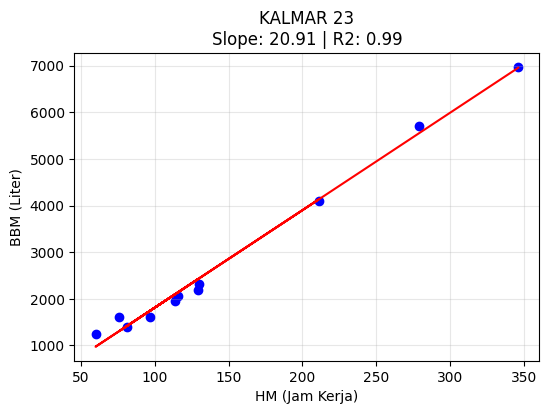

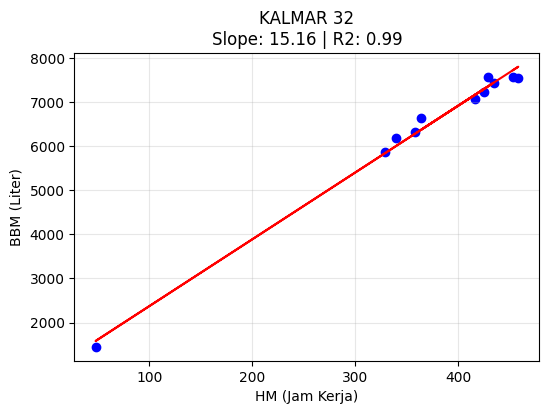

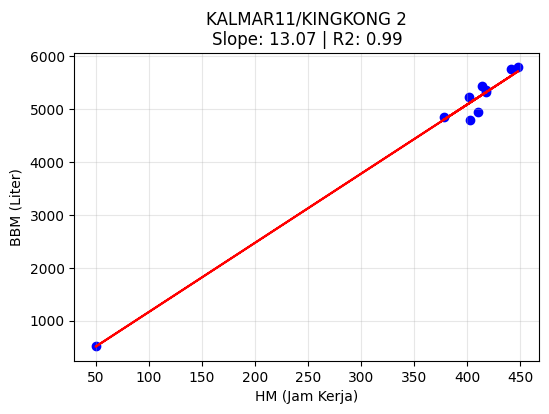

In [3]:
regression_results = []
min_months = 3 

units = df_monthly['Unit_Name'].unique()

print(f"📊 Melakukan Regresi pada {len(units)} Unit...")

for unit in units:
    df_u = df_monthly[df_monthly['Unit_Name'] == unit]
    
    # Filter Valid (Hanya bulan dimana unit bekerja dan isi bbm)
    df_u = df_u[(df_u['HM'] > 0) & (df_u['LITER'] > 0)]
    
    if len(df_u) >= min_months:
        x_val = df_u['HM'].values
        y_val = df_u['LITER'].values
        
        # --- REGRESI LINEAR DENGAN NUMPY ---
        # Slope (m) = Konsumsi per jam
        # Intercept (c) = Fixed cost/Idling loss
        slope, intercept = np.polyfit(x_val, y_val, 1)
        
        # Hitung Prediksi & R2
        predict_func = np.poly1d([slope, intercept])
        y_pred = predict_func(x_val)
        
        ss_res = np.sum((y_val - y_pred) ** 2)
        ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
        
        r2 = 0
        if ss_tot != 0: r2 = 1 - (ss_res / ss_tot)
        
        avg_ratio = df_u['LITER'].sum() / df_u['HM'].sum()
        
        regression_results.append({
            'Unit_Name': unit,
            'Data_Points': len(df_u),
            'Intercept_Base_Load': intercept,
            'Slope_Liter_Per_HM': slope,
            'Average_Ratio_Manual': avg_ratio,
            'R2_Score_Accuracy': r2,
            'Status_Model': 'Valid' if r2 > 0.5 else 'Data Acak/Tidak Konsisten'
        })

df_regresi = pd.DataFrame(regression_results)
df_regresi = df_regresi.sort_values('R2_Score_Accuracy', ascending=False)

# Simpan Excel
output_regresi = 'Hasil_Analisa_Regresi_Unit_Fix.xlsx'
df_regresi.to_excel(output_regresi, index=False)

print(f"✅ Selesai! Hasil disimpan di: {output_regresi}")
print("\nTop 5 Unit Paling Konsisten:")
print(df_regresi[['Unit_Name', 'Slope_Liter_Per_HM', 'R2_Score_Accuracy']].head())

# --- PLOT SAMPLE ---
def plot_regression(unit_name):
    df_u = df_monthly[(df_monthly['Unit_Name'] == unit_name) & (df_monthly['HM'] > 0)]
    if len(df_u) < 2: return
    
    x = df_u['HM'].values
    y = df_u['LITER'].values
    m, c = np.polyfit(x, y, 1)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color='blue')
    plt.plot(x, m*x + c, color='red')
    plt.title(f"{unit_name}\nSlope: {m:.2f} | R2: {df_regresi[df_regresi['Unit_Name']==unit_name]['R2_Score_Accuracy'].values[0]:.2f}")
    plt.xlabel("HM (Jam Kerja)"); plt.ylabel("BBM (Liter)")
    plt.grid(True, alpha=0.3); plt.show()

# Tampilkan 3 terbaik
for u in df_regresi.head(3)['Unit_Name']: plot_regression(u)